# Nodes Classification with Vanilla Graph Neural Networks

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import Planetoid, FacebookPagePage
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

## Download the Cora dataset using Planetoid

In [2]:
# Load the Cora dataset - a citation network where:
# - Nodes: Scientific papers (2,708 papers)
# - Edges: Citation links between papers
# - Features: Bag-of-words representation (1,433 unique words)
# - Labels: 7 research categories
dataset = Planetoid(root=".", name="Cora")

Processing...
Done!


In [3]:
# Access the single graph in the dataset
data = dataset[0]

In [4]:
print("CORA DATASET INFORMATION")
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of node features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of edges: {data.edge_index.shape[1]}')
print("\nGraph Properties:")
print(f'  - Directed edges: {data.is_directed()}')
print(f'  - Has isolated nodes: {data.has_isolated_nodes()}')
print(f'  - Has self-loops: {data.has_self_loops()}')

CORA DATASET INFORMATION
Dataset: Cora()
Number of graphs: 1
Number of nodes: 2708
Number of node features: 1433
Number of classes: 7
Number of edges: 10556

Graph Properties:
  - Directed edges: False
  - Has isolated nodes: False
  - Has self-loops: False


## Plotting The Graph using NetworkX

In [5]:
def visualize_graph(data, title="Graph Visualization"):
    """
    Visualize the graph structure with node colors representing classes
    
    Args:
        data: PyTorch Geometric data object
        title: Title for the plot
    """
    # Convert to NetworkX for visualization
    graph = to_networkx(data, to_undirected=True)
    
    # Extract node labels for coloring
    node_colors = [data.y[i].item() for i in range(len(data.y))]
    
    # Use Fruchterman-Reingold force-directed layout for better visualization
    pos = nx.fruchterman_reingold_layout(graph, seed=42)
    
    # Create the plot
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.title(title, fontsize=16)
    nx.draw_networkx(
        graph, pos, 
        node_color=node_colors, 
        cmap=plt.get_cmap('coolwarm'),
        node_size=20,
        with_labels=False,
        width=0.1,
        alpha=0.8
    )
    plt.show()

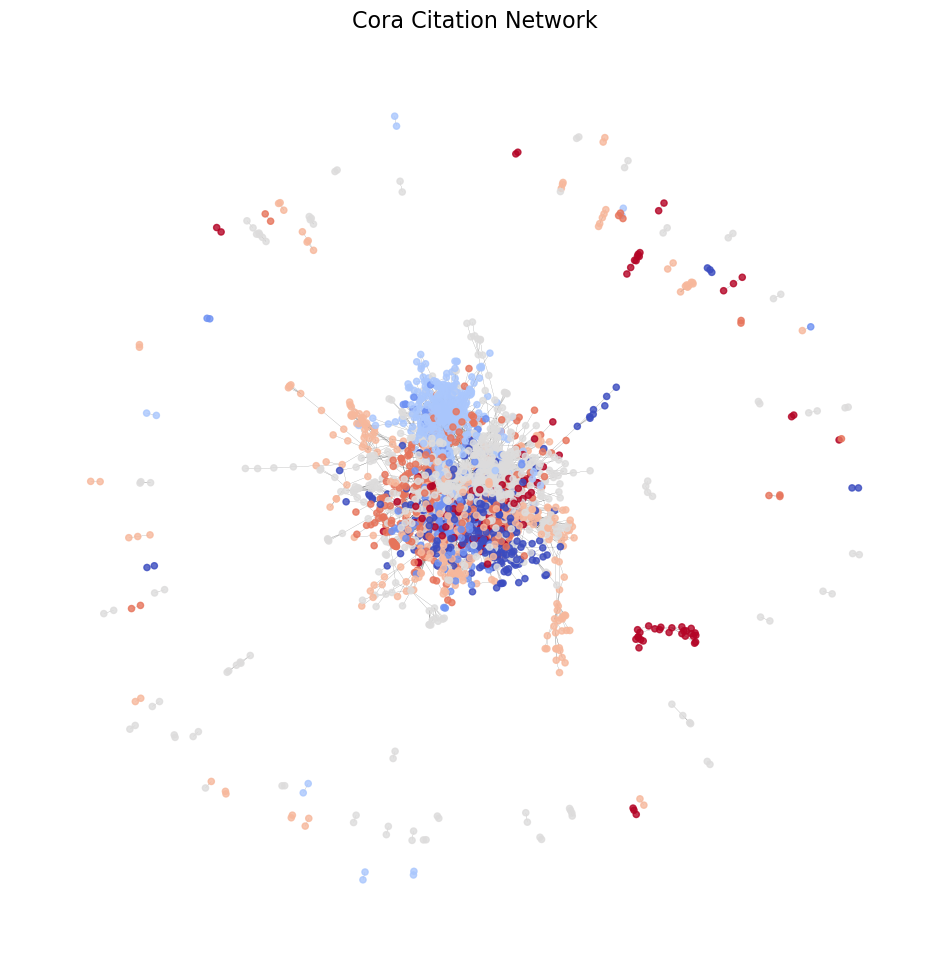

In [6]:
# Visualize the Cora citation network
visualize_graph(data, "Cora Citation Network")

# Export graph to GraphML format for external analysis
nx.write_graphml(to_networkx(data, to_undirected=True), 'cora_graph.graphml')

## Node features as a regular tabular dataset

In [9]:
# Convert sparse feature matrix to DataFrame for easier inspection
# Features are bag-of-words: each column represents a word, 1=present, 0=absent
df_x = pd.DataFrame(data.x.numpy())
df_x['label'] = data.y.numpy()

print("\nFeature Matrix Shape:", df_x.shape)
print("\nFirst 5 rows of feature matrix:")
df_x.head()


Feature Matrix Shape: (2708, 1434)

First 5 rows of feature matrix:


,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [8]:
df_x

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2704,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Implementing Multi-Llayer Perceptron (MLP) BASELINE MODEL

In [10]:
# Initialize lists to track training metrics
mlp_train_losses, mlp_val_losses = [], []
mlp_train_accs, mlp_val_accs = [], []

class MLP(torch.nn.Module):
    """
    Standard Multi-Layer Perceptron (MLP) for node classification.
    
    This model treats each node independently and doesn't use graph structure.
    It serves as a baseline to demonstrate the value of incorporating graph topology.
    
    Architecture:
        Input Layer → Hidden Layer (ReLU) → Output Layer (Log Softmax)
    """
    
    def __init__(self, dim_in, dim_h, dim_out):
        """
        Initialize the MLP layers.
        
        Args:
            dim_in: Input feature dimension
            dim_h: Hidden layer dimension
            dim_out: Output dimension (number of classes)
        """
        super().__init__()
        # First linear transformation: features → hidden
        self.linear1 = Linear(dim_in, dim_h)
        # Second linear transformation: hidden → classes
        self.linear2 = Linear(dim_h, dim_out)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Node feature matrix [num_nodes, num_features]
            
        Returns:
            Log probabilities for each class [num_nodes, num_classes]
        """
        # First layer with ReLU activation
        x = self.linear1(x)
        x = torch.relu(x)
        
        # Output layer with log softmax for numerical stability
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)
    
    def accuracy(self, y_pred, y_true):
        """
        Calculate classification accuracy.
        
        Args:
            y_pred: Predicted class labels
            y_true: Ground truth labels
            
        Returns:
            Accuracy as a float between 0 and 1
        """
        return torch.sum(y_pred == y_true) / len(y_true)
    
    def fit(self, data, epochs):
        """
        Train the MLP model.
        
        Args:
            data: PyTorch Geometric data object with train/val masks
            epochs: Number of training epochs
            
        Returns:
            self: Trained model
        """
        # Define loss function and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=0.01,  # Learning rate
            weight_decay=5e-4  # L2 regularization to prevent overfitting
        )
        
        self.train()  # Set model to training mode
        
        for epoch in range(epochs + 1):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            
            # Forward pass: compute predictions for all nodes
            out = self(data.x)
            
            # Compute loss only on training nodes
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            
            # Calculate training accuracy
            acc = self.accuracy(
                out[data.train_mask].argmax(dim=1), 
                data.y[data.train_mask]
            )
            
            # Backward pass: compute gradients
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Log metrics every 20 epochs
            if epoch % 20 == 0:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = self.accuracy(
                    out[data.val_mask].argmax(dim=1), 
                    data.y[data.val_mask]
                )
                
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                      f'{acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: '
                      f'{val_acc*100:.2f}%')
                
                # Store metrics for visualization
                mlp_train_losses.append(loss.item())
                mlp_val_losses.append(val_loss.item())
                mlp_train_accs.append(acc.item())
                mlp_val_accs.append(val_acc.item())
        
        return self
    
    def test(self, data):
        """
        Evaluate model on test set.
        
        Args:
            data: PyTorch Geometric data object with test mask
            
        Returns:
            Test accuracy
        """
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation
            out = self(data.x)
            acc = self.accuracy(
                out.argmax(dim=1)[data.test_mask], 
                data.y[data.test_mask]
            )
        return acc

In [11]:
# Create MLP instance
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)

# Train the model
mlp.fit(data, epochs=100)

# Test the model
test_acc = mlp.test(data)

print(f'MLP Test Accuracy: {test_acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=1433, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=7, bias=True)
)
Epoch   0 | Train Loss: 1.948 | Train Acc: 15.71% | Val Loss: 1.99 | Val Acc: 11.80%
Epoch  20 | Train Loss: 0.081 | Train Acc: 100.00% | Val Loss: 1.35 | Val Acc: 55.20%
Epoch  40 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.50 | Val Acc: 52.00%
Epoch  60 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.46 | Val Acc: 50.80%
Epoch  80 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.37 | Val Acc: 54.80%
Epoch 100 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.35 | Val Acc: 54.20%
MLP Test Accuracy: 56.20%


## Implementing The Vanilla GNN Model

In [13]:
# Initialize lists for GNN metrics
gnn_train_losses, gnn_val_losses = [], []
gnn_train_accs, gnn_val_accs = [], []

class VanillaGNNLayer(nn.Module):
    """
    A single layer of Vanilla Graph Neural Network.
    
    This layer implements the core GNN operation:
    1. Transform node features with a linear layer
    2. Aggregate features from neighbors using the adjacency matrix
    
    Formula: H' = A @ W @ H
    where:
        H = input node features
        W = learnable weight matrix
        A = adjacency matrix
        H' = output node features
    """
    
    def __init__(self, dim_in, dim_out):
        """
        Initialize the GNN layer.
        
        Args:
            dim_in: Input feature dimension
            dim_out: Output feature dimension
        """
        super(VanillaGNNLayer, self).__init__()
        # Linear transformation without bias (bias can be added if needed)
        self.linear = Linear(dim_in, dim_out, bias=False)
    
    def forward(self, x, adjacency):
        """
        Forward pass: transform and aggregate features.
        
        Args:
            x: Node features [num_nodes, dim_in]
            adjacency: Adjacency matrix [num_nodes, num_nodes]
            
        Returns:
            Updated node features [num_nodes, dim_out]
        """
        # Step 1: Apply linear transformation to node features
        x = self.linear(x)
        
        # Step 2: Aggregate features from neighbors
        # Sparse matrix multiplication is efficient for large graphs
        x = torch.sparse.mm(adjacency, x)
        
        return x

class VanillaGNN(nn.Module):
    """
    Two-layer Vanilla Graph Neural Network for node classification.
    
    This model leverages graph structure by aggregating information from
    neighboring nodes. It typically outperforms MLP on graph-structured data.
    
    Architecture:
        Input → GNN Layer 1 (ReLU) → GNN Layer 2 → Log Softmax
    """
    
    def __init__(self, dim_in, dim_h, dim_out):
        """
        Initialize the GNN model.
        
        Args:
            dim_in: Input feature dimension
            dim_h: Hidden layer dimension
            dim_out: Output dimension (number of classes)
        """
        super().__init__()
        # First GNN layer: features → hidden
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        # Second GNN layer: hidden → classes
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)
    
    def forward(self, x, adjacency):
        """
        Forward pass through the GNN.
        
        Args:
            x: Node feature matrix [num_nodes, num_features]
            adjacency: Adjacency matrix [num_nodes, num_nodes]
            
        Returns:
            Log probabilities for each class [num_nodes, num_classes]
        """
        # First GNN layer with ReLU activation
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        
        # Second GNN layer with log softmax
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)
    
    def accuracy(self, y_pred, y_true):
        """Calculate classification accuracy."""
        return torch.sum(y_pred == y_true) / len(y_true)
    
    def fit(self, data, epochs, adjacency):
        """
        Train the GNN model.
        
        Args:
            data: PyTorch Geometric data object
            epochs: Number of training epochs
            adjacency: Preprocessed adjacency matrix
            
        Returns:
            self: Trained model
        """
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=0.01, 
            weight_decay=5e-4
        )
        
        self.train()
        
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            
            # Forward pass with graph structure
            out = self(data.x, adjacency)
            
            # Compute loss on training nodes
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            
            # Calculate training accuracy
            acc = self.accuracy(
                out[data.train_mask].argmax(dim=1), 
                data.y[data.train_mask]
            )
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Log metrics every 20 epochs
            if epoch % 20 == 0:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = self.accuracy(
                    out[data.val_mask].argmax(dim=1), 
                    data.y[data.val_mask]
                )
                
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                      f'{acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: '
                      f'{val_acc*100:.2f}%')
                
                # Store metrics
                gnn_train_losses.append(loss.item())
                gnn_val_losses.append(val_loss.item())
                gnn_train_accs.append(acc.item())
                gnn_val_accs.append(val_acc.item())
        
        return self
    
    def test(self, data, adjacency):
        """
        Evaluate model on test set.
        
        Args:
            data: PyTorch Geometric data object
            adjacency: Adjacency matrix
            
        Returns:
            Test accuracy
        """
        self.eval()
        with torch.no_grad():
            out = self(data.x, adjacency)
            acc = self.accuracy(
                out.argmax(dim=1)[data.test_mask], 
                data.y[data.test_mask]
            )
        return acc

### Preparing the Adjacency Matrix used in message passing

In [15]:
# Convert edge list to dense adjacency matrix
adjacency = to_dense_adj(data.edge_index)[0]

# Add self-loops: each node includes its own features in aggregation
# This is crucial for preserving node's own information during message passing
adjacency += torch.eye(len(adjacency))

print("\nAdjacency Matrix Shape:", adjacency.shape)
print("Number of edges (including self-loops):", adjacency.sum().item())
adjacency


Adjacency Matrix Shape: torch.Size([2708, 2708])
Number of edges (including self-loops): 13264.0


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

In [16]:
# Create GNN instance
gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)

# Train the model
gnn.fit(data, epochs=100, adjacency=adjacency)

# Test the model
gnn_acc = gnn.test(data, adjacency=adjacency)
print(f'GNN Test Accuracy: {gnn_acc*100:.2f}%')

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)
Epoch   0 | Train Loss: 2.522 | Train Acc: 15.71% | Val Loss: 2.31 | Val Acc: 16.60%
Epoch  20 | Train Loss: 0.066 | Train Acc: 98.57% | Val Loss: 1.38 | Val Acc: 72.60%
Epoch  40 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 1.98 | Val Acc: 73.80%
Epoch  60 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 2.07 | Val Acc: 75.80%
Epoch  80 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 2.05 | Val Acc: 74.80%
Epoch 100 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 1.99 | Val Acc: 74.40%
GNN Test Accuracy: 73.60%



MLP Training Visualization:


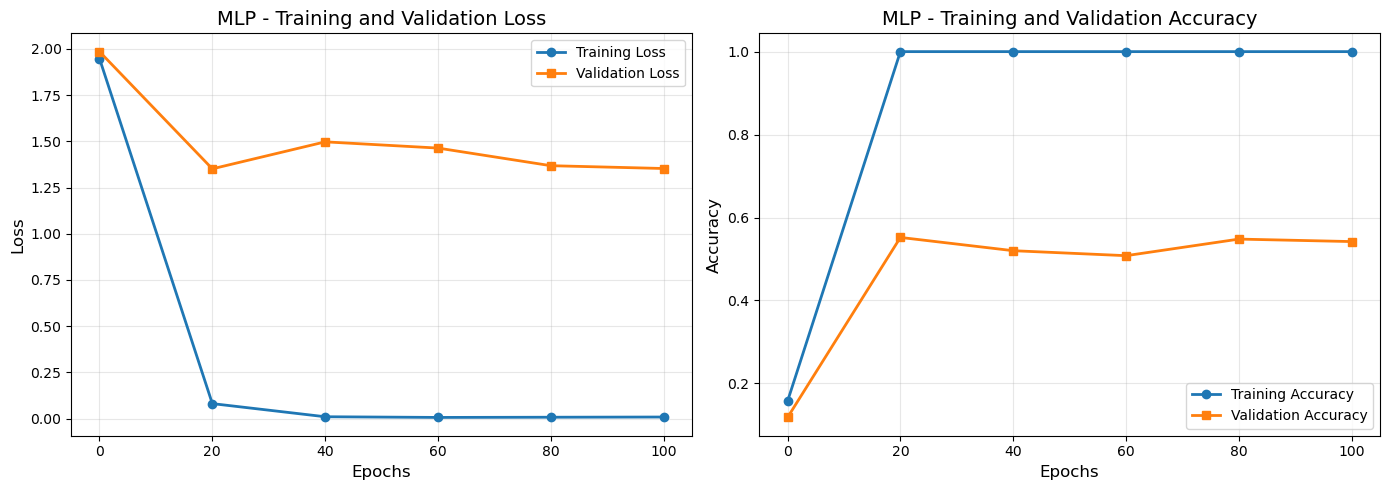


GNN Training Visualization:


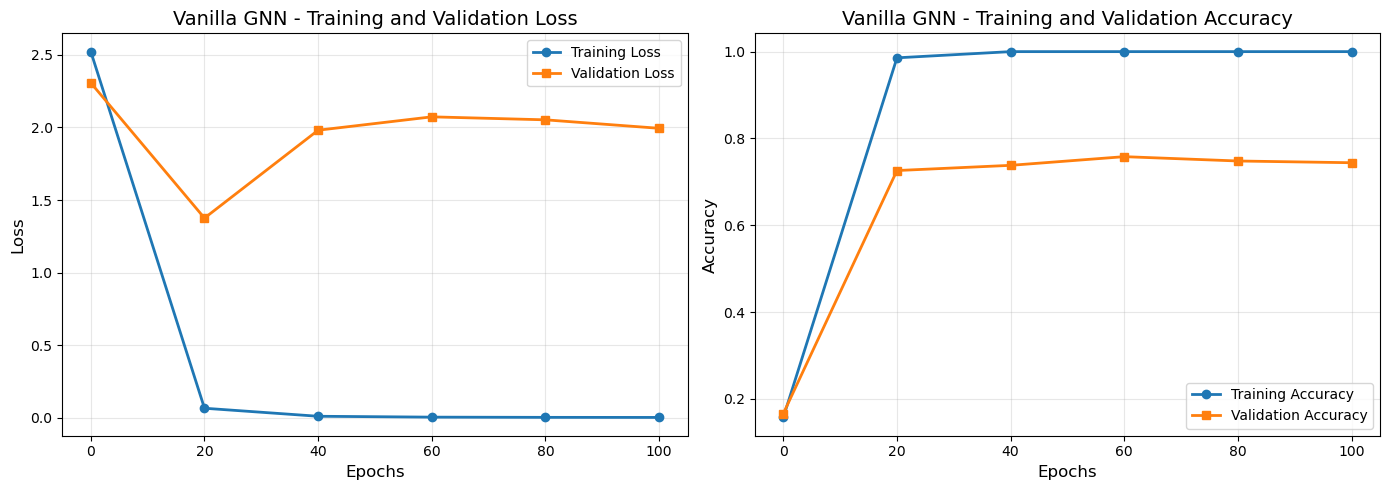

In [18]:
def plot_training_metrics(train_losses, val_losses, train_accs, val_accs, 
                         model_name="Model"):
    """
    Plot training and validation metrics.
    
    Args:
        train_losses: List of training losses
        val_losses: List of validation losses
        train_accs: List of training accuracies
        val_accs: List of validation accuracies
        model_name: Name of the model for the title
    """
    epochs = range(0, 101, 20)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot losses
    ax1.plot(epochs, train_losses, label='Training Loss', marker='o', linewidth=2)
    ax1.plot(epochs, val_losses, label='Validation Loss', marker='s', linewidth=2)
    ax1.set_title(f'{model_name} - Training and Validation Loss', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracies
    ax2.plot(epochs, train_accs, label='Training Accuracy', marker='o', linewidth=2)
    ax2.plot(epochs, val_accs, label='Validation Accuracy', marker='s', linewidth=2)
    ax2.set_title(f'{model_name} - Training and Validation Accuracy', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot MLP metrics
print("\nMLP Training Visualization:")
plot_training_metrics(mlp_train_losses, mlp_val_losses, 
                      mlp_train_accs, mlp_val_accs, "MLP")

# Plot GNN metrics
print("\nGNN Training Visualization:")
plot_training_metrics(gnn_train_losses, gnn_val_losses, 
                      gnn_train_accs, gnn_val_accs, "Vanilla GNN")

## Models Comparaison

In [19]:
print("MODEL COMPARISON RESULTS")
print("="*60)
print(f"Dataset: Cora")
print(f"MLP Test Accuracy: {test_acc*100:.2f}%")
print(f"GNN Test Accuracy: {gnn_acc*100:.2f}%")
print(f"Improvement: {(gnn_acc - test_acc)*100:.2f} percentage points")
print(f"Relative Boost: {((gnn_acc - test_acc) / test_acc * 100):.2f}%")

MODEL COMPARISON RESULTS
Dataset: Cora
MLP Test Accuracy: 56.20%
GNN Test Accuracy: 73.60%
Improvement: 17.40 percentage points
Relative Boost: 30.96%


## Challenge:

The Facebook Page-Page dataset This dataset was introduced by Rozemberczki et al. in 2019 [2]. In this dataset, each of the 22,470 nodes represents an official Facebook page.
Pages are connected when there are mutual likes between them. Node features (128-dim vectors) are created from textual descriptions written by the owners of these pages. Our goal is to classify each node into one of four categories: politicians, companies, television shows, and governmental organizations.

The Facebook Page-Page dataset is similar to the Cora dataset: it’s a social network with a node classification task. However, there are three major differences with Cora:
-  The number of nodes is much higher (2,708 versus 22,470)
-  The dimensionality of the node features decreased dramatically (from 1,433 to 128)
-  The goal is to classify each node into four categories instead of seven (which is easier since there are fewer options)

In [28]:
print("Loading from local files: musae_facebook_*.csv/json")
# Import additional libraries for loading custom data
import json
from torch_geometric.data import Data

def load_facebook_dataset(path="facebook_large"):
    """
    Load the Facebook Page-Page dataset from local files.
    
    Args:
        path: Directory containing the dataset files
        
    Returns:
        data: PyTorch Geometric Data object
        num_classes: Number of target classes
    """
    import os
    import numpy as np
    
    # Load edges
    print("Loading edges...")
    edges_df = pd.read_csv(os.path.join(path, "musae_facebook_edges.csv"))
    # Convert to numpy first to avoid warning
    edge_array = np.array([edges_df['id_1'].values, edges_df['id_2'].values])
    edge_index = torch.tensor(edge_array, dtype=torch.long)
    
    # Load target labels
    print("Loading target labels...")
    target_df = pd.read_csv(os.path.join(path, "musae_facebook_target.csv"))
    # Sort by id to ensure correct ordering
    target_df = target_df.sort_values('id').reset_index(drop=True)
    
    # Convert string labels to numeric indices
    # Check if labels are strings or already numeric
    if target_df['page_type'].dtype == 'object' or target_df['page_type'].dtype.name.startswith('str'):
        # Labels are strings, need to encode them
        from sklearn.preprocessing import LabelEncoder
        label_encoder = LabelEncoder()
        numeric_labels = label_encoder.fit_transform(target_df['page_type'].values)
        y = torch.tensor(numeric_labels, dtype=torch.long)
        print(f"Label classes: {list(label_encoder.classes_)}")
    else:
        # Labels are already numeric
        y = torch.tensor(target_df['page_type'].values, dtype=torch.long)
    
    # Load features from JSON
    print("Loading node features...")
    with open(os.path.join(path, "musae_facebook_features.json"), 'r') as f:
        features_dict = json.load(f)
    
    # Convert features dictionary to matrix
    # Features are stored as sparse format, need to convert to dense
    num_nodes = len(features_dict)
    
    # Find the maximum feature index to determine feature dimension
    max_feature_idx = 0
    for node_id, feature_list in features_dict.items():
        if feature_list:  # Check if list is not empty
            max_feature_idx = max(max_feature_idx, max(feature_list))
    
    num_features = max_feature_idx + 1
    print(f"Detected {num_features} features")
    
    # Create feature matrix (one-hot encoding style)
    x = torch.zeros((num_nodes, num_features), dtype=torch.float)
    for node_id, feature_list in features_dict.items():
        node_idx = int(node_id)
        for feature_idx in feature_list:
            x[node_idx, feature_idx] = 1.0
    
    # Create Data object
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Get number of classes
    num_classes = len(torch.unique(y))
    
    print(f"\nDataset loaded successfully!")
    print(f"Nodes: {data.num_nodes}")
    print(f"Edges: {data.num_edges}")
    print(f"Features: {num_features}")
    print(f"Classes: {num_classes}")
    
    return data, num_classes

# Load the Facebook dataset
data_fb, num_classes_fb = load_facebook_dataset("facebook_large")

# Create train/val/test masks (not provided by default)
# Use the same split strategy as suggested in the original notebook
num_nodes = data_fb.num_nodes
data_fb.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data_fb.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data_fb.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Calculate split points
train_size = int(0.8 * num_nodes)  # 80% for training
val_size = int(0.1 * num_nodes)    # 10% for validation
# Remaining 10% for test

data_fb.train_mask[:train_size] = True
data_fb.val_mask[train_size:train_size + val_size] = True
data_fb.test_mask[train_size + val_size:] = True

print(f"\nDataset Split:")
print(f"Training nodes: {data_fb.train_mask.sum().item()}")
print(f"Validation nodes: {data_fb.val_mask.sum().item()}")
print(f"Test nodes: {data_fb.test_mask.sum().item()}")
print(f"Has isolated nodes: {data_fb.has_isolated_nodes()}")
print(f"Has self-loops: {data_fb.has_self_loops()}")
print("="*60)

Loading from local files: musae_facebook_*.csv/json
Loading edges...
Loading target labels...
Label classes: ['company', 'government', 'politician', 'tvshow']
Loading node features...
Detected 4714 features

Dataset loaded successfully!
Nodes: 22470
Edges: 171002
Features: 4714
Classes: 4

Dataset Split:
Training nodes: 17976
Validation nodes: 2247
Test nodes: 2247
Has isolated nodes: False
Has self-loops: True


In [24]:
# Your MLP Solution
# Initialize metric tracking for Facebook MLP
fb_mlp_train_losses, fb_mlp_val_losses = [], []
fb_mlp_train_accs, fb_mlp_val_accs = [], []

# Create MLP model for Facebook dataset
print("\n" + "="*60)
print("TRAINING MLP ON FACEBOOK PAGE-PAGE DATASET")
print("="*60)

mlp_fb = MLP(data_fb.x.shape[1], 64, num_classes_fb)
print(mlp_fb)
print(f"Model parameters: {sum(p.numel() for p in mlp_fb.parameters()):,}")

# Train MLP on Facebook dataset
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_fb.parameters(), lr=0.01, weight_decay=5e-4)

mlp_fb.train()
print("\nTraining MLP...")
for epoch in range(101):
    optimizer.zero_grad()
    out = mlp_fb(data_fb.x)
    loss = criterion(out[data_fb.train_mask], data_fb.y[data_fb.train_mask])
    acc = mlp_fb.accuracy(out[data_fb.train_mask].argmax(dim=1), 
                          data_fb.y[data_fb.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        val_loss = criterion(out[data_fb.val_mask], data_fb.y[data_fb.val_mask])
        val_acc = mlp_fb.accuracy(out[data_fb.val_mask].argmax(dim=1), 
                                  data_fb.y[data_fb.val_mask])
        
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
              f'{acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: '
              f'{val_acc*100:.2f}%')
        
        fb_mlp_train_losses.append(loss.item())
        fb_mlp_val_losses.append(val_loss.item())
        fb_mlp_train_accs.append(acc.item())
        fb_mlp_val_accs.append(val_acc.item())

# Test MLP on Facebook dataset
fb_mlp_test_acc = mlp_fb.test(data_fb)
print(f'\n{"="*60}')
print(f'Facebook MLP Test Accuracy: {fb_mlp_test_acc*100:.2f}%')
print("="*60)


TRAINING MLP ON FACEBOOK PAGE-PAGE DATASET
MLP(
  (linear1): Linear(in_features=4714, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=4, bias=True)
)
Model parameters: 302,020

Training MLP...
Epoch   0 | Train Loss: 1.390 | Train Acc: 31.24% | Val Loss: 1.39 | Val Acc: 30.31%
Epoch  20 | Train Loss: 0.267 | Train Acc: 92.11% | Val Loss: 0.33 | Val Acc: 89.99%
Epoch  40 | Train Loss: 0.219 | Train Acc: 93.43% | Val Loss: 0.31 | Val Acc: 90.12%
Epoch  60 | Train Loss: 0.198 | Train Acc: 94.15% | Val Loss: 0.30 | Val Acc: 90.52%
Epoch  80 | Train Loss: 0.181 | Train Acc: 94.53% | Val Loss: 0.30 | Val Acc: 90.70%
Epoch 100 | Train Loss: 0.167 | Train Acc: 94.89% | Val Loss: 0.30 | Val Acc: 90.65%

Facebook MLP Test Accuracy: 90.16%


In [25]:
# Your Vanilla GNN Solution
# Initialize metric tracking for Facebook GNN
fb_gnn_train_losses, fb_gnn_val_losses = [], []
fb_gnn_train_accs, fb_gnn_val_accs = [], []

# Prepare adjacency matrix for Facebook dataset
print("\nPreparing adjacency matrix for Facebook dataset...")
print("(This may take a moment for large graphs...)")
adjacency_fb = to_dense_adj(data_fb.edge_index)[0]
adjacency_fb += torch.eye(len(adjacency_fb))
print(f"Adjacency matrix shape: {adjacency_fb.shape}")
print(f"Memory usage: ~{adjacency_fb.element_size() * adjacency_fb.nelement() / (1024**2):.1f} MB")

# Create GNN model for Facebook dataset
print("\n" + "="*60)
print("TRAINING VANILLA GNN ON FACEBOOK PAGE-PAGE DATASET")
print("="*60)

gnn_fb = VanillaGNN(data_fb.x.shape[1], 64, num_classes_fb)
print(gnn_fb)
print(f"Model parameters: {sum(p.numel() for p in gnn_fb.parameters()):,}")

# Train GNN on Facebook dataset
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gnn_fb.parameters(), lr=0.01, weight_decay=5e-4)

gnn_fb.train()
print("\nTraining GNN...")
for epoch in range(101):
    optimizer.zero_grad()
    out = gnn_fb(data_fb.x, adjacency_fb)
    loss = criterion(out[data_fb.train_mask], data_fb.y[data_fb.train_mask])
    acc = gnn_fb.accuracy(out[data_fb.train_mask].argmax(dim=1), 
                          data_fb.y[data_fb.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        val_loss = criterion(out[data_fb.val_mask], data_fb.y[data_fb.val_mask])
        val_acc = gnn_fb.accuracy(out[data_fb.val_mask].argmax(dim=1), 
                                  data_fb.y[data_fb.val_mask])
        
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
              f'{acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: '
              f'{val_acc*100:.2f}%')
        
        fb_gnn_train_losses.append(loss.item())
        fb_gnn_val_losses.append(val_loss.item())
        fb_gnn_train_accs.append(acc.item())
        fb_gnn_val_accs.append(val_acc.item())

# Test GNN on Facebook dataset
fb_gnn_test_acc = gnn_fb.test(data_fb, adjacency_fb)
print(f'\n{"="*60}')
print(f'Facebook GNN Test Accuracy: {fb_gnn_test_acc*100:.2f}%')
print("="*60)


Preparing adjacency matrix for Facebook dataset...
(This may take a moment for large graphs...)
Adjacency matrix shape: torch.Size([22470, 22470])
Memory usage: ~1926.0 MB

TRAINING VANILLA GNN ON FACEBOOK PAGE-PAGE DATASET
VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=4714, out_features=64, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=64, out_features=4, bias=False)
  )
)
Model parameters: 301,952

Training GNN...
Epoch   0 | Train Loss: 2.875 | Train Acc: 29.22% | Val Loss: 1.47 | Val Acc: 28.66%
Epoch  20 | Train Loss: 0.834 | Train Acc: 87.92% | Val Loss: 0.92 | Val Acc: 85.80%
Epoch  40 | Train Loss: 0.536 | Train Acc: 89.24% | Val Loss: 0.81 | Val Acc: 86.25%
Epoch  60 | Train Loss: 0.474 | Train Acc: 90.58% | Val Loss: 0.76 | Val Acc: 86.87%
Epoch  80 | Train Loss: 0.378 | Train Acc: 91.75% | Val Loss: 0.72 | Val Acc: 86.87%
Epoch 100 | Train Loss: 0.321 | Train Acc: 92.72% | Val Loss: 0.67 | Val Acc: 87.58%

Facebook GNN


Facebook MLP Training Visualization:


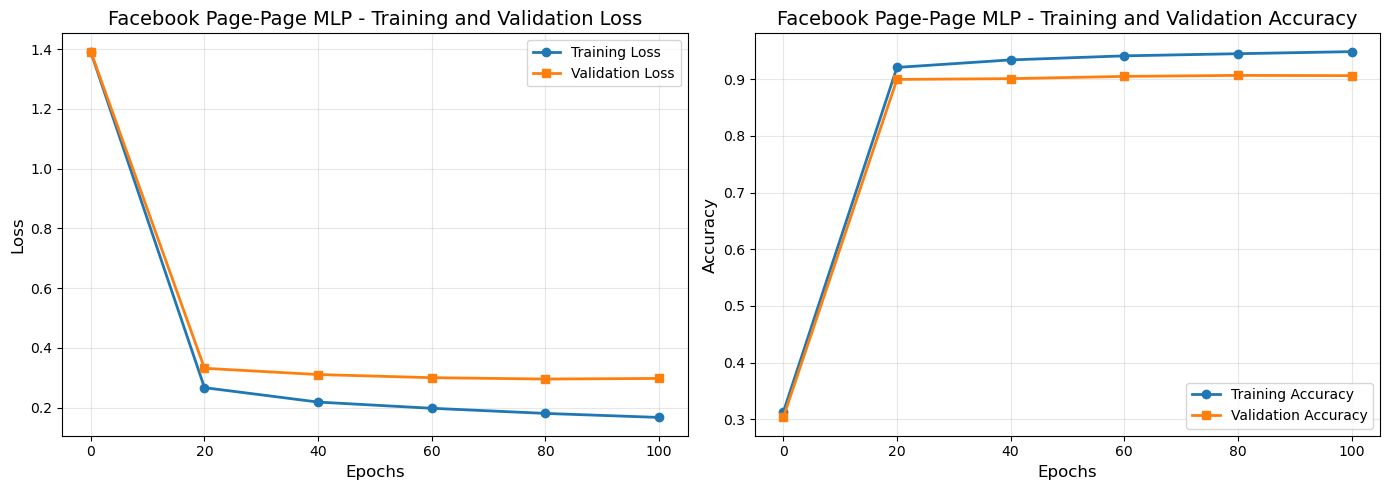


Facebook GNN Training Visualization:


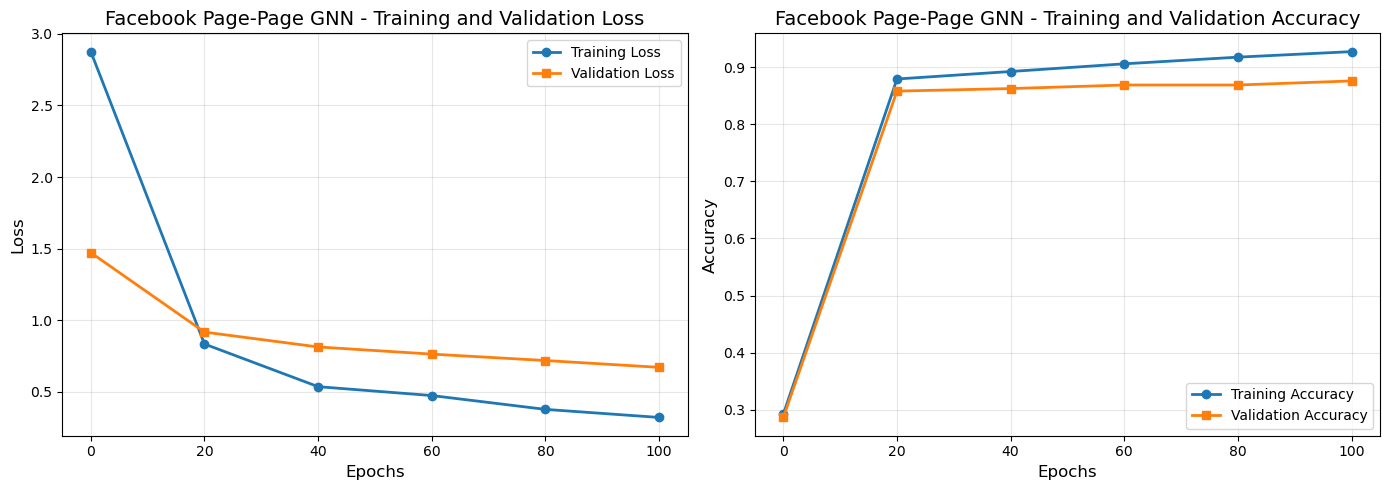

In [26]:
# Plot MLP metrics for Facebook
print("\nFacebook MLP Training Visualization:")
plot_training_metrics(fb_mlp_train_losses, fb_mlp_val_losses, 
                      fb_mlp_train_accs, fb_mlp_val_accs, "Facebook Page-Page MLP")

# Plot GNN metrics for Facebook
print("\nFacebook GNN Training Visualization:")
plot_training_metrics(fb_gnn_train_losses, fb_gnn_val_losses, 
                      fb_gnn_train_accs, fb_gnn_val_accs, "Facebook Page-Page GNN")

In [30]:
print("\n" + "="*70)
print("FINAL MODEL COMPARISON - ALL RESULTS")
print("="*70)
print(f"{'Dataset':<20} {'MLP Acc':<15} {'GNN Acc':<15} {'Boost':<20}")
print("-"*70)

# Cora results
cora_boost = (gnn_acc - test_acc) * 100
cora_boost_pct = ((gnn_acc - test_acc) / test_acc * 100)
print(f"{'Cora':<20} {test_acc*100:>6.2f}%{'':<8} {gnn_acc*100:>6.2f}%{'':<8} "
      f"+{cora_boost:.2f}pp ({cora_boost_pct:+.2f}%)")

# Facebook results
fb_boost = (fb_gnn_test_acc - fb_mlp_test_acc) * 100
fb_boost_pct = ((fb_gnn_test_acc - fb_mlp_test_acc) / fb_mlp_test_acc * 100)
print(f"{'Facebook Page-Page':<20} {fb_mlp_test_acc*100:>6.2f}%{'':<8} "
      f"{fb_gnn_test_acc*100:>6.2f}%{'':<8} "
      f"+{fb_boost:.2f}pp ({fb_boost_pct:+.2f}%)")


print("\nDataset Characteristics:")
print(f"  Cora: {data.num_nodes:,} nodes, {dataset.num_features:,} features, "
      f"{dataset.num_classes} classes")
print(f"  Facebook: {data_fb.num_nodes:,} nodes, {data_fb.x.shape[1]:,} features, "
      f"{num_classes_fb} classes")



FINAL MODEL COMPARISON - ALL RESULTS
Dataset              MLP Acc         GNN Acc         Boost               
----------------------------------------------------------------------
Cora                  56.20%          73.60%         +17.40pp (+30.96%)
Facebook Page-Page    90.16%          85.36%         +-4.81pp (-5.33%)

Dataset Characteristics:
  Cora: 2,708 nodes, 1,433 features, 7 classes
  Facebook: 22,470 nodes, 4,714 features, 4 classes
